In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [35]:
data_raw = pd.read_csv('Mall_Customers.xls')
data = data_raw.copy()

In [36]:
data = data.dropna()
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [37]:
data = data.drop(columns = 'CustomerID')
# data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
X = data[['Annual Income (k$)', 'Spending Score (1-100)']]

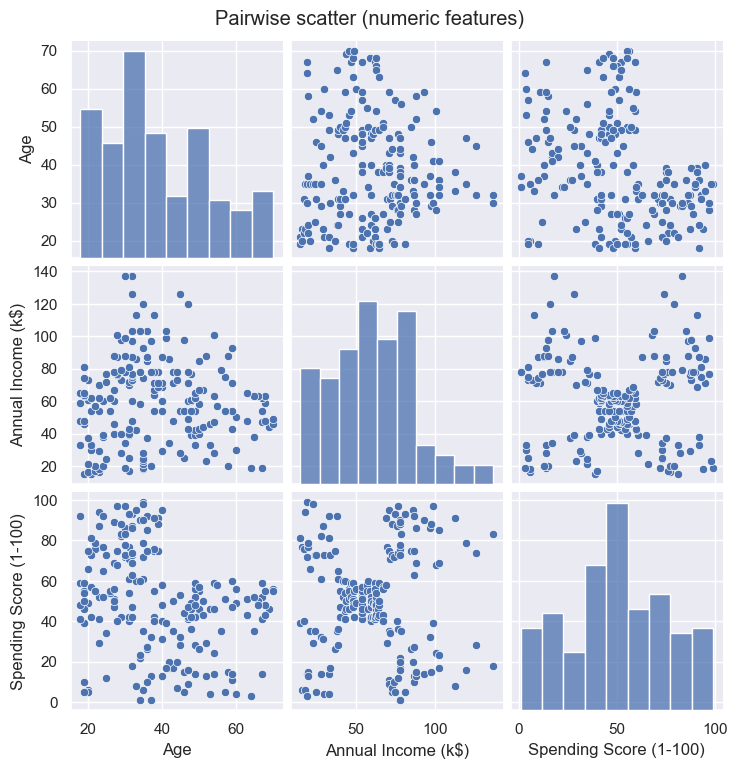

In [38]:
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
sns.pairplot(data[num_cols])
# sns.pairplot(data, vars=num_cols, hue='Gender', diag_kind='hist')
plt.suptitle("Pairwise scatter (numeric features)", y=1.02)
plt.show()

In [39]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

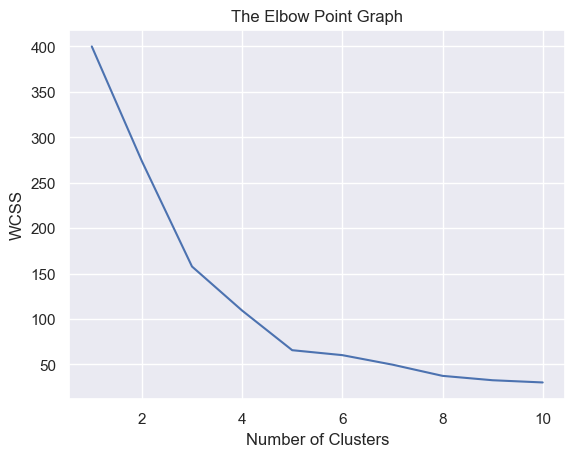

In [40]:
# WCSS vs clusters
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(scaled_data)
  wcss.append(kmeans.inertia_)

# Elbow Point Graph
sns.set()
plt.plot(range(1,11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
labels = kmeans.fit_predict(scaled_data)

In [42]:
print("Silhouette Score (K-Means):", silhouette_score(scaled_data, labels))

Silhouette Score (K-Means): 0.5546571631111091


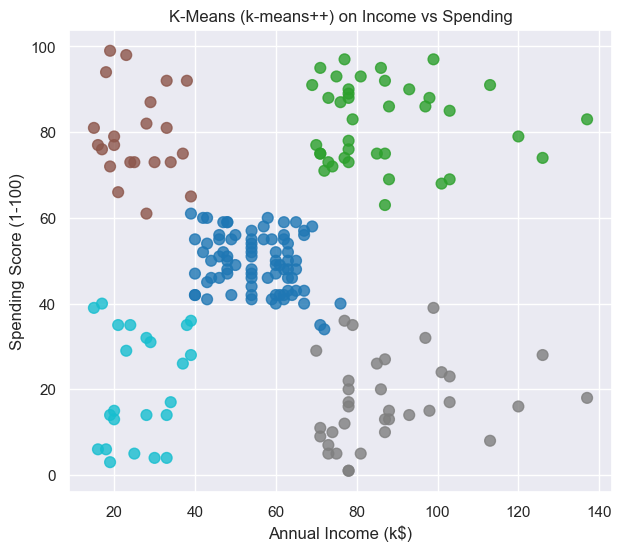

In [43]:
data_clusters = data.copy()
data_clusters['Cluster'] = labels

# Quick 2D plot (just for human-friendly view)
plt.figure(figsize=(7,6))
plt.scatter(data_clusters['Annual Income (k$)'], data_clusters['Spending Score (1-100)'],
            c=data_clusters['Cluster'], s=60, alpha=0.8, cmap='tab10')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means (k-means++) on Income vs Spending")
plt.show()

In [44]:
# Mean values of numeric features per cluster
cluster_means = data_clusters.groupby('Cluster').mean(numeric_only=True)

# Size of each cluster
cluster_sizes = data_clusters['Cluster'].value_counts().sort_index()

# Genre proportion per cluster
gender_share = (
    data_clusters.groupby('Cluster')['Genre']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .rename(columns=lambda c: f"P({c})")
    .round(2)
)

# Combine everything into one compact profile
cluster_profile = pd.concat([cluster_means, cluster_sizes.rename('Count'), gender_share], axis=1)
cluster_profile


,Age,Annual Income (k$),Spending Score (1-100),Count,P(Female),P(Male)
Cluster,,,,,,
0,42.716049,55.296296,49.518519,81,0.59,0.41
1,32.692308,86.538462,82.128205,39,0.54,0.46
2,25.272727,25.727273,79.363636,22,0.59,0.41
3,41.114286,88.200000,17.114286,35,0.46,0.54
4,45.217391,26.304348,20.913043,23,0.61,0.39


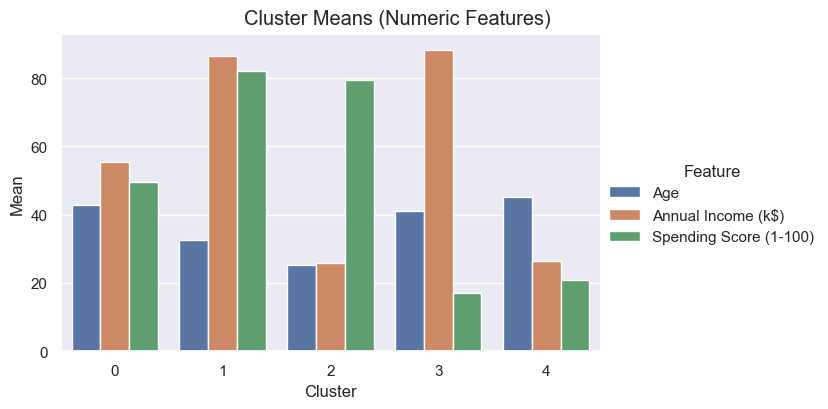

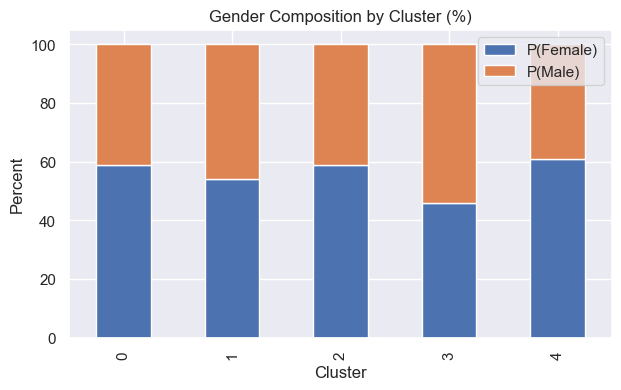

In [45]:
# Bar plot: mean values per cluster
means_long = cluster_means.reset_index().melt(
    id_vars='Cluster', var_name='Feature', value_name='Mean'
)

g = sns.catplot(
    data=means_long, x='Cluster', y='Mean', hue='Feature',
    kind='bar', height=4, aspect=1.6
)
g.fig.suptitle("Cluster Means (Numeric Features)", y=1.02)
plt.show()

# Stacked bar: gender proportions
(gender_share * 100).plot(
    kind='bar', stacked=True, figsize=(7,4)
)
plt.ylabel("Percent")
plt.title("Gender Composition by Cluster (%)")
plt.legend(loc='best')
plt.show()


In [46]:
cluster_labels = {
    0: "Mid Income, Mid Spend",
    1: "Low Income, High Spend",
    2: "Low Income, Low Spend",
    3: "High Income, High Spend",
    4: "High Income, Low Spend"
}

cluster_profile = cluster_profile.copy()
cluster_profile["Segment"] = cluster_profile.index.map(cluster_labels)

cluster_profile

,Age,Annual Income (k$),Spending Score (1-100),Count,P(Female),P(Male),Segment
Cluster,,,,,,,
0,42.716049,55.296296,49.518519,81,0.59,0.41,"Mid Income, Mid Spend"
1,32.692308,86.538462,82.128205,39,0.54,0.46,"Low Income, High Spend"
2,25.272727,25.727273,79.363636,22,0.59,0.41,"Low Income, Low Spend"
3,41.114286,88.200000,17.114286,35,0.46,0.54,"High Income, High Spend"
4,45.217391,26.304348,20.913043,23,0.61,0.39,"High Income, Low Spend"


#Business Use Cases

#1. Marketing Campaigns

High Income, High Spend (Cluster 3) → Target with luxury/premium products (e.g., exclusive offers, VIP memberships).

Low Income, High Spend (Cluster 1 – “Impulsive Buyers”) → Attract with discounts, flash sales, and limited-time deals.

High Income, Low Spend (Cluster 4 – “Careful Buyers”) → Retain with loyalty programs, cashback rewards, and value-based bundles.

Low Income, Low Spend (Cluster 2) → Don’t allocate big marketing budgets; only low-cost engagement campaigns (e.g., newsletters).

Mid Income, Mid Spend (Cluster 0) → Nurture as steady customers, upsell mid-range products.

# 2. Product Recommendation

Cluster 3 (High Income, High Spend) → Recommend premium brands, luxury goods, and add-on services.

Cluster 1 (Low Income, High Spend) → Suggest trendy, fast-moving items with discounts.

Cluster 4 (High Income, Low Spend) → Push practical, durable, and high-value products.

Cluster 2 (Low Income, Low Spend) → Keep budget-friendly/basic products in focus.

Cluster 0 (Mid Income, Mid Spend) → Offer a balanced mix of affordable and aspirational products.

# 3. Branch/Store Strategy

Cluster 3 Areas → Open premium stores or flagship outlets.

Cluster 1 Areas → Place stores with frequent promotions/seasonal offers.

Cluster 4 Areas → Focus on value-driven stores with loyalty-driven services.

Cluster 2 Areas → Limit investment, keep small/basic outlets.

Cluster 0 Areas → Standard stores with balanced inventory.

In [49]:
# --- 1) Data: features (X) and target (y) ---
use_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)", "Genre"]
data_clusters['Segment'] = data_clusters['Cluster'].map(cluster_labels)
X = data_clusters[use_cols].copy()
y = data_clusters["Segment"].copy()

# --- 2) Train / test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- 3) Preprocessing ---
numeric_features = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
categorical_features = ["Genre"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# --- 4) Candidate models ---
models = {
    "logreg": LogisticRegression(max_iter=200, n_jobs=None),  # simple baseline
    "rf": RandomForestClassifier(n_estimators=300, random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
}

# --- 5) Cross-validate and pick the best by macro-F1 ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("clf", clf)])
    f1 = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="f1_macro")
    acc = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    results[name] = {"f1_macro_mean": f1.mean(), "f1_macro_std": f1.std(),
                     "acc_mean": acc.mean(), "acc_std": acc.std()}

pd.DataFrame(results).T.sort_values("f1_macro_mean", ascending=False)

,f1_macro_mean,f1_macro_std,acc_mean,acc_std
rf,0.987870,0.015373,0.986667,0.016330
gb,0.967810,0.040832,0.966667,0.036515
logreg,0.944403,0.032762,0.953333,0.016330


In [50]:
# --- 6) Train the best model on the full training set ---
best_name = max(results, key=lambda k: results[k]["f1_macro_mean"])
best_clf = models[best_name]

best_pipe = Pipeline(steps=[("prep", preprocessor), ("clf", best_clf)])
best_pipe.fit(X_train, y_train)

print(f"Best model (CV): {best_name}")

Best model (CV): rf



Classification Report:
                          precision    recall  f1-score   support

High Income, High Spend       1.00      1.00      1.00         9
 High Income, Low Spend       1.00      0.83      0.91         6
 Low Income, High Spend       1.00      1.00      1.00        10
  Low Income, Low Spend       0.83      1.00      0.91         5
  Mid Income, Mid Spend       0.95      0.95      0.95        20

               accuracy                           0.96        50
              macro avg       0.96      0.96      0.95        50
           weighted avg       0.96      0.96      0.96        50



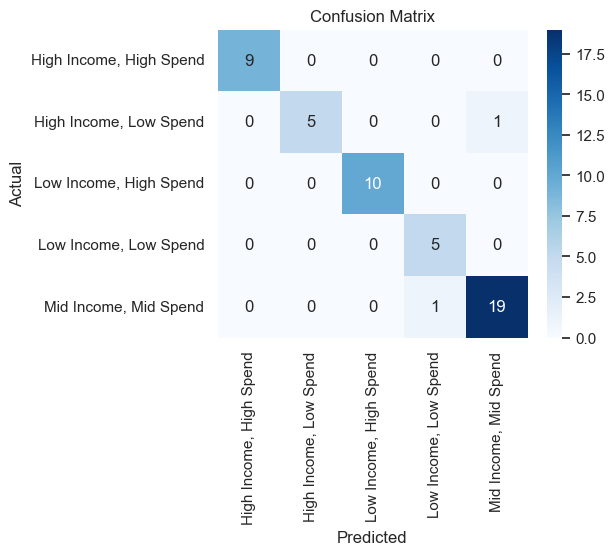

In [52]:
# --- 7) Evaluate on hold-out test set ---
y_pred = best_pipe.predict(X_test)

report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nClassification Report:\n", report)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_pipe.classes_, yticklabels=best_pipe.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [54]:
# --- 8) Predict on new customers (example) ---
new_customers = pd.DataFrame([
    {"Age": 28, "Annual Income (k$)": 30, "Spending Score (1-100)": 75, "Genre": "Female"},
    {"Age": 46, "Annual Income (k$)": 90, "Spending Score (1-100)": 22, "Genre": "Male"},
    {"Age": 35, "Annual Income (k$)": 55, "Spending Score (1-100)": 50, "Genre": "Female"},
])

pred_segments = best_pipe.predict(new_customers)
pd.concat([new_customers, pd.Series(pred_segments, name="Predicted Segment")], axis=1)



,Age,Annual Income (k$),Spending Score (1-100),Genre,Predicted Segment
0,28,30,75,Female,"Low Income, Low Spend"
1,46,90,22,Male,"High Income, High Spend"
2,35,55,50,Female,"Mid Income, Mid Spend"
